In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

from utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

In [ ]:
(x_train,y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

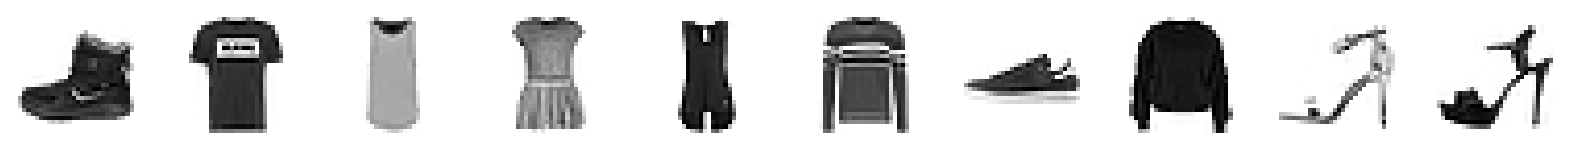

In [ ]:
# Show some items of clothing from the training set
display(x_train)

These are 28 x 28 grayscale images iwth pixel values between 0 and 255
It needs to be preprocessed to scale the pixel values between 0 and 1
We will also pad each image into 32x32 for easier manipulation of tensor shape as it passes through the network

In [ ]:
def preprocess(imgs):
  imgs = imgs.astype("float32")/255.0
  imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values =0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs

In [ ]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [ ]:
# Constructing an Autoencoder
encoder_input = layers.Input(shape=(32,32,1), name='encoder_input')
x = layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name='encoder_output')(x)   # to create 2 dimensional embedding vector
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

In [ ]:
# The Decoder
decoder_input = layers.Input(shape=(2,), name='decoder_input') # Define the Input layer of the decoder(the embedding)
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input) #Connect input to Dense layer
x = layers.Reshape(shape_before_flattening)(x)    # Reshape vector into tensor that can be fed top Transpose layer
x = layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, activation='relu', padding='same')(x)
decoder_output = layers.Conv2D(1, (3,3), strides=1, activation='sigmoid', padding='same', name='decoder_output')(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       1846

In [ ]:
# Joining encoder and decoder
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

In [ ]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train, epochs=5, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/5
600/600 [==============================] - 296s 489ms/step - loss: 0.2899 - val_loss: 0.2606
Epoch 2/5
600/600 [==============================] - 287s 478ms/step - loss: 0.2570 - val_loss: 0.2556
Epoch 3/5
600/600 [==============================] - 285s 475ms/step - loss: 0.2538 - val_loss: 0.2542
Epoch 4/5
600/600 [==============================] - 294s 490ms/step - loss: 0.2517 - val_loss: 0.2526
Epoch 5/5
600/600 [==============================] - 293s 488ms/step - loss: 0.2505 - val_loss: 0.2512


In [ ]:
# Reconstruct the images
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 8s 49ms/step
Example real clothing items


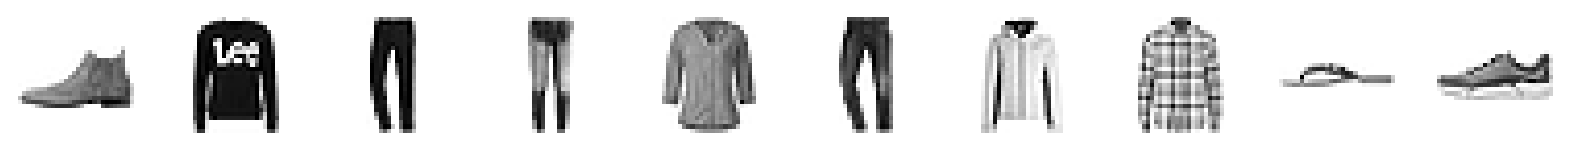

Reconstructions


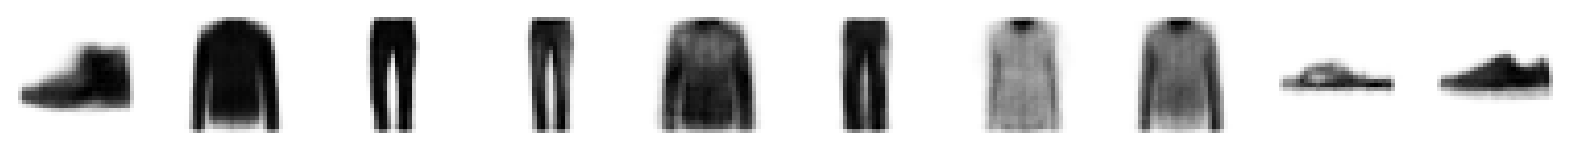

In [ ]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

In [ ]:
# Embed using the encoder
embeddings = encoder.predict(example_images)
# Some examples of the embeddings
print(embeddings[:10])

157/157 [==============================] - 2s 10ms/step
[[ 0.27612025  2.661441  ]
 [ 6.555703   -1.7080771 ]
 [-0.92889607 -7.384882  ]
 [-0.9581151  -4.4215035 ]
 [ 3.4897683  -0.4049734 ]
 [ 0.1758294  -5.5233016 ]
 [ 1.5079585  -0.95500356]
 [ 2.7261798  -0.8750273 ]
 [-1.1939154   0.4746361 ]
 [-1.3830488   1.8269044 ]]


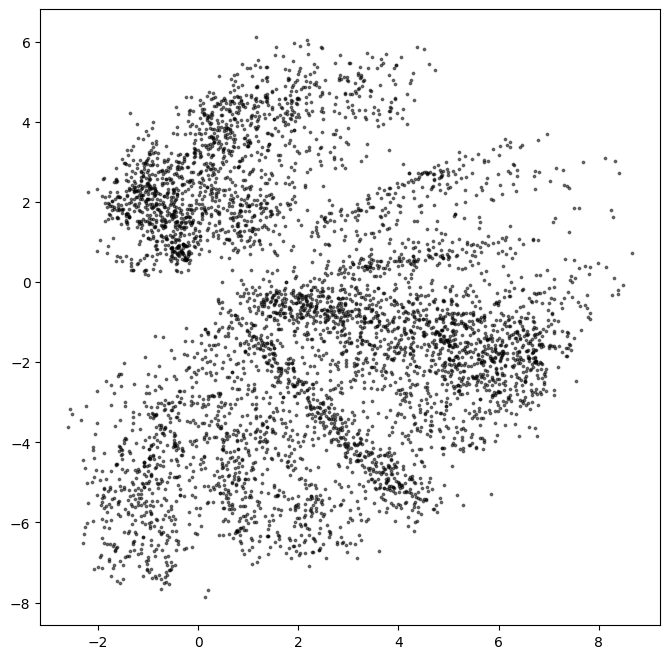

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

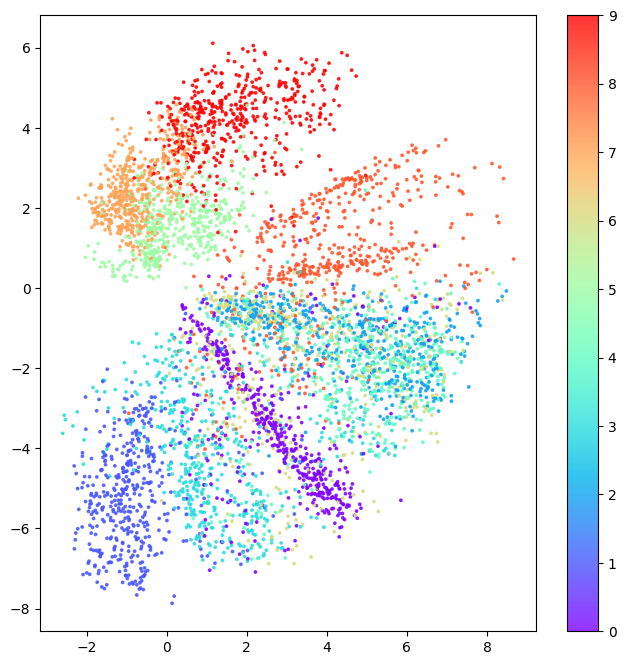

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()


In [ ]:
# Generate using the decoder
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 297ms/step


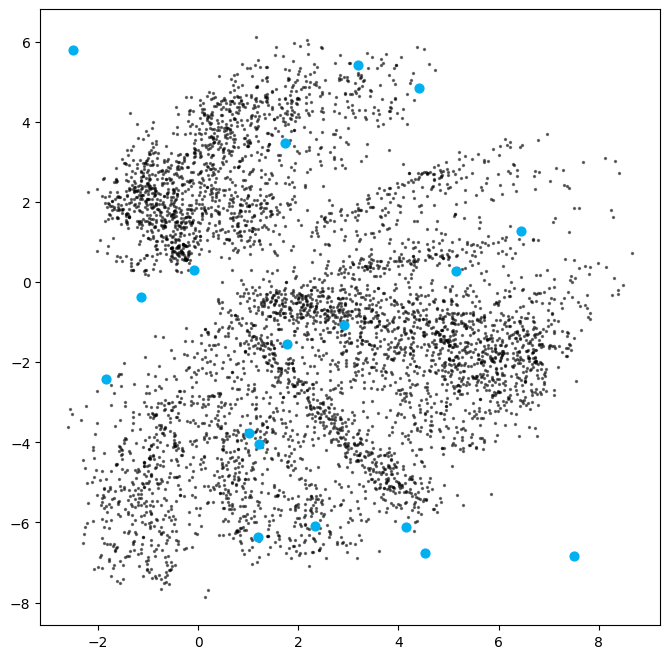

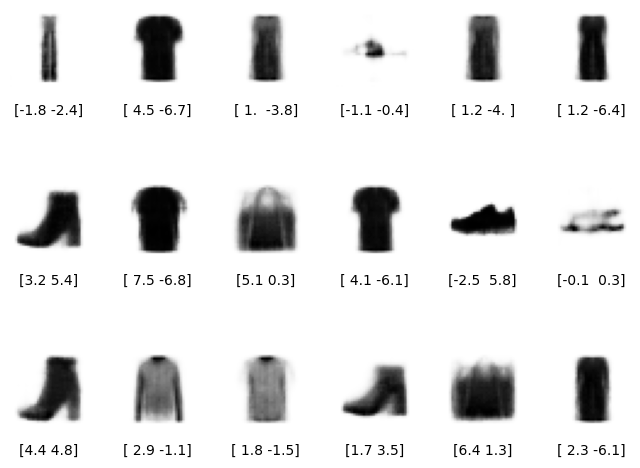

In [ ]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 1s 62ms/step


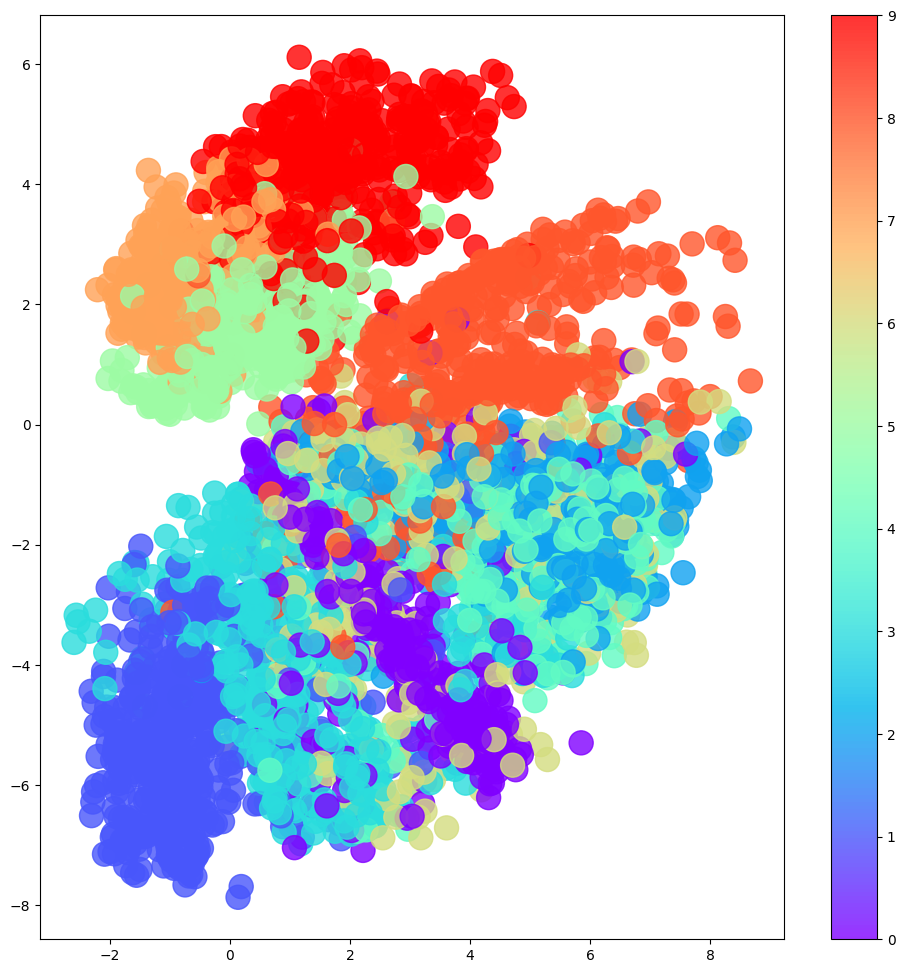

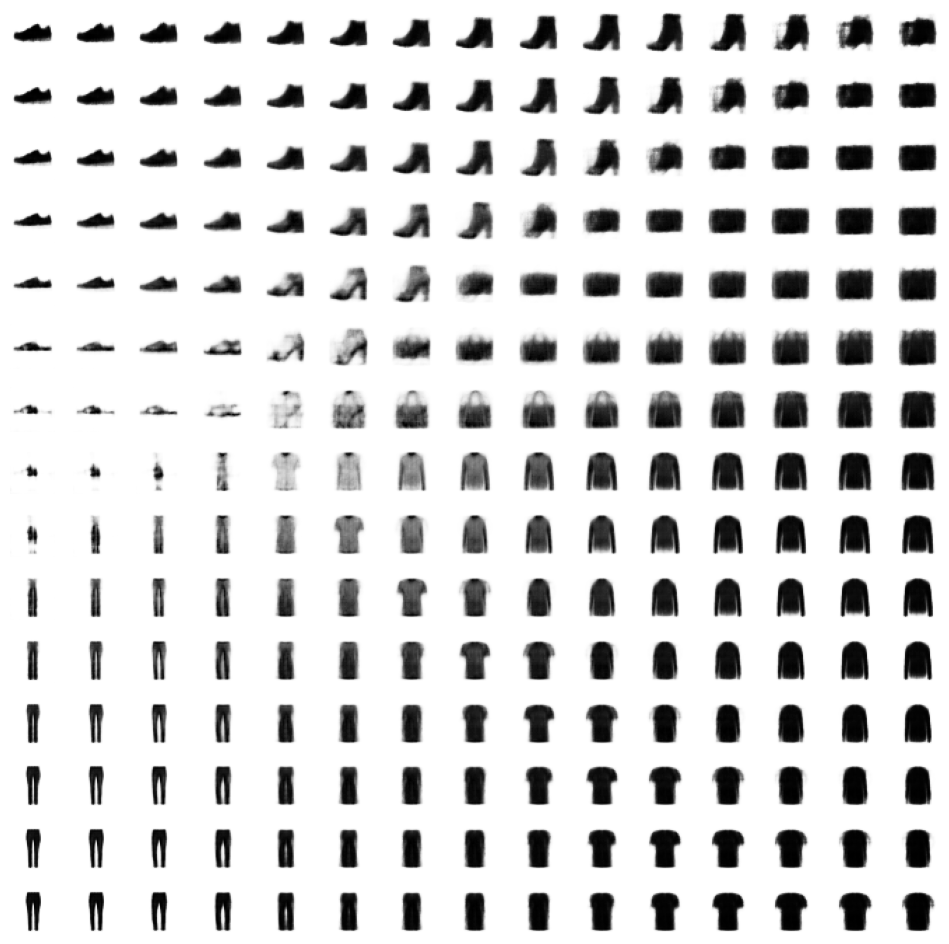

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")